# Method of Moment for 3D Plate

## Import Packages

In [2]:
try
    using Gmsh: gmsh, Gmsh 
catch
    using gmsh
end 

using LinearAlgebra  
using SparseArrays 
using StaticArrays

using BenchmarkTools

using Test 

using CairoMakie

In [3]:
# a point in 2D is a tuple of 2 coordinates 
const Point2D = SVector{2,Float64};

## Section 1: Introduction 

### Problem Formulation 

#### Computational Domain 

The computational domain $\Omega$ is a thin rectangular plate in the $xy$ plane of thickness $t_p$ in the $z$-direction.

#### Background Field 

Assume $\mathbf{H}_0(\mathbf{x}) = H_{0,x}(\mathbf{x}) \mathbf{i} + H_{0,y}(\mathbf{x}) \mathbf{j} + H_{0,z}(\mathbf{x}) \mathbf{k}$ to denote the background field. Assume $\mathbf{H}_0(\mathbf{x}) = H_{0,x} \mathbf{i}$ with $H_x$ a constant in first numerical tests. 

#### Plate Magnetization 

Denote by $\mathbf{M}(\mathbf{x}) = M_x(\mathbf{x}) \mathbf{i} + M_y(\mathbf{x}) \mathbf{j} +  M_z(\mathbf{x}) \mathbf{k}$ the magnetization vector in the plate. 

#### Problem to Solve 

Given background field $\mathbf{H}_0(\mathbf{x})$, solve for the magnetization vector $\mathbf{M}(\mathbf{x})$. 

### Numerical Solution Approach 

#### Mesh 

Assume a mesh of first order thin prismatic elements with $N_e$ elements and $N_n$ nodes. This mesh is generated by first meshing the $xy$ and subsequently extruding the mesh in the $z$-direction. Assume ${\cal P}^h = \{ \mathbf{e}_k \}$ for $1 \leq k \leq N_e$ to denote the set elements. Assume a destination and source element to be denoted by $e_k^d$ and $e_{\ell}^s$, respectively. 

The nodal first order Lagrangian shape functions of the element $\phi_{\alpha}(x,y)$ for $1 \leq \alpha \leq 3$ are $z$-independent. The integration over $\Omega$ with factor $1 /  \| \mathbf{r}^d - \mathbf{r}^s\|$ introduces a $z$-dependency in the computed magnetization. 

Integration over element $e_k^d$ of $z$-independent integrand $f(x,y)$ is given by 

$$
\int_{e_k^d} f(x,y) dV =  t_p \int_{e_k^d} f(x,y) dA  
$$

#### Poisson Equation: Element-by-Element Linear System Assembly 

We wish to assemble the linear system by a loop over the elements $e^k$ in the mesh. We wish to show how the local matrix and vector can be obtained by differentiating the local residual vector with respect to the expansion coefficients. We illustrate the concept here for a two-dimensional Poisson problem discretized using P1 elements. Assume that the element $e^k$ supports the basis functions $\phi_{\alpha}(x,y)$ for $\alpha \in \{1,\ldots,\text{ndof} \}$. The elememt matrix contribion is constructed using the following three steps (assuming here that $\text{ndof} = 3$): 

1. construct the local approximation to the solution on element $e^k$ as a sum of local basis functions $\phi_{\alpha}(x,y)$ with expansion coefficients $c_i$; 

$$ u^{k,loc}(x,y) = c_1 \phi_1(x,y) + c_2 \phi_2(x,y) + c_3 \phi_3(x,y) \, .$$ 

2. construct the local residual vector by weighting averaging over the element;  

$$ r^{k}_{\alpha} = \int_{e^k} \nabla u^{loc}(x,y) \cdot \nabla \phi_{\alpha}(x,y) dx \, dy \text{ for } \alpha \in \{ 1,\ldots,3 \} \, .$$ 

3. construct local stiffness matrix as the Jacobian of the residual vector differentiated wrt to the expansion coefficients by calling the function <i>ForwardDiff.jacobian</i>;

$$ A^k = \nabla_{\mathbf{c}} \mathbf{r}^{k,loc} = [a_{\alpha} \, a_{\beta} + b_{\alpha} \, b_{\beta}]_{1 \leq \alpha, \beta \leq 3} \, .$$
   
#### MoM: Element-by-Element Linear System Assembly 

We wish to assemble the MoM linear system $A \mathbf{m} = \mathbf{b}$ of size $3N_n \times 3N_n$ by a loop over destination elements $e_k^d \in {\cal P}^h$.  The matrix $A\in{\cal R}^{3N_n \times 3N_n}$ is a $3 \times 3$ block matrix with blocks of size $N_n$. The vectors $\mathbf{m}\in{\cal R}^{3N_n}$ and $\mathbf{b}\in{\cal R}^{3N_n}$ are block vectors with $3$ blocks of size $N_n$. 

$$
A = \sum_{k=1}^{N_e} \sum_{\ell=1}^{N_e} A^{k\ell} \text{ where }
\mathbf{A}^k = \begin{pmatrix} 
A_{xx}^{k\ell} & A_{xy}^{k\ell} & A_{xz}^{k\ell} \\
A_{yx}^{k\ell} & A_{yy}^{k\ell} & A_{yz}^{k\ell} \\
A_{zx}^{k\ell}& A_{zy}^{k\ell} & A_{zz}^{k\ell}
\end{pmatrix} \in {\cal R}^{9 \times 9} 
$$

and

$$
\mathbf{b} = \sum_{k=1}^{N_e} \mathbf{b}^k \text{ where }
\mathbf{b}^k = \begin{pmatrix} \mathbf{b}_x^k \\ \mathbf{b}_y^k \\ \mathbf{b}_z^k \end{pmatrix} \in {\cal R}^9 
$$ 

#### MoM: Construction of the Element Right-Hand Side Vector $\mathbf{b}^k$

In the following notations, the index $r \in \{x,y,z\}$ loops over the carthesian coordinate axes and the index $\alpha \in \{1,2,3\}$ loops over the degrees of freedom per element. 

$$
\mathbf{b}_{r,\alpha}^k = t_p \int_{e_k^d} H_{0,r} \, \phi_{\alpha}(x,y) \, dA_d  
\text{ for } r \in \{x,y,z\} \text{ and for } \alpha \in \{1,2,3\}
$$

Assuming that $H_{0,r}$ is constant over $e_k^d$, this extression reduces to 

$$
\mathbf{b}_{r,\alpha}^k = \frac{1}{3} \, t_p \, \text{area}(e_k^d) \, H_{0,r}
\text{ for } r \in \{x,y,z\} \text{ and for } \alpha \in \{1,2,3\}
$$

#### MoM: Construction of the Element Matrix $A^{k\ell}$ 

In the following notations, the indeces $r,s \in \{x,y,z\}$ loop over the carthesian coordinate axes and the indices $\alpha, \beta\in \{1,2,3\}$ loops over the degrees of freedom per element.

$$
A_{rs,\alpha \beta}^{k\ell} = \int_{e_k^d} \phi_{\alpha}(x,y) \, \text{grad}_{\mathbf{r}_d} \text{div}_{\mathbf{r}_d}
\int_{e_{\ell}^s} \frac{\phi_{\beta}(x,y)}{\| \mathbf{r}_d - \mathbf{r}_s \|} \, dV_s \, dV_d
$$

#### MoM: Construction of the Element Matrix First Diagonal Block $A^{k\ell}_{xx}$

We wish to compute the first diagonal block $A^{k\ell}_{xx}$ as the Jacobian with respect to expansion coefficients of a local residual vector. We therefore proceed as follows:  

1. construct the local approximation to the solution on element $e_s^{\ell}$ as a sum of local basis functions $\phi_{\alpha}(x,y)$ with expansion coefficients $c_i$; 

$$ M^{\ell}_x(x_s,y_s) = c_1 \phi_1(x_s,y_s) + c_2 \phi_2(x_s,y_s) + c_3 \phi_3(x_s,y_s) \text{ on } e_{\ell}^s \, $$ 

2. scale $M^{\ell}_x(\mathbf{x})(x,y)$ with the distance $\| \mathbf{r}_d - \mathbf{r}_s \|$ to obtain the inner integrand. Use numerical integration over the element $e_{\ell}^s$ to obtain the inner integral

$$ I^{k\ell}_{inner}(\mathbf{r}_d) = \int_{e_{\ell}^s} \frac{M_x(x_s,y_s)}{\| \mathbf{r}_d - \mathbf{r}_s \|} \, dV_s $$

3. compute the second order partial derivative of $I^{k\ell}_{inner}(\mathbf{r}_d)$ with respect to $x_d$ using the function <i>ForwardDiff.derivative()</i> twice 
   
4. construct the local residual vector by weighting averaging over the destination element $e_d^k$ using numerical integration 

$$ r^{k,loc}_{\alpha} = \int_{e_k^d} \frac{\partial^2}{\partial x_d^2} \left[ \int_{e_{\ell}^s} \frac{M_x(x_s,y_s)}{\| \mathbf{r}_d - \mathbf{r}_s \|} \, dV_s \right] \phi_{\alpha}(x_d,y_d) dV_d \text{ for } \alpha \in \{ 1,\ldots,3 \} \, .$$ 

5. construct local stiffness matrix as the Jacobian of the residual vector differentiated wrt to the expansion coefficients $\mathbf{c}$ by calling the function <i>ForwardDiff.jacobian</i>;

   

## Section 2: Two-Dimensional Mesh Generation

In [4]:
"""
    struct Element 

Holds information for a single linear triangular element. 
"""
struct Element
  p1::Point2D                   # coordinates first node 
  p2::Point2D                   # coordinates second node 
  p3::Point2D                   # coordinates third node     
  e1::Int64                     # global index first node
  e2::Int64                     # global index second node
  e3::Int64                     # global index third node
  Emat::MMatrix{3,3,Float64, 9} # matrix of basis function coefficients 
  area::Float64                 # area of the element 
end

"""
    struct Mesh 

Holds information for the entire mesh as an array of linear triangular elements. 
"""
struct Mesh
  nnodes::Int64               # number of nodes 
  nelems::Int64               # number of elements
  dofPerElem::Int64           # number of dofs per element   
  Elements::Array{Element,1}  # list of Elements 
  bndNodeIds::Vector{Int64}   # indices of nodes where Dirichlet bc are applied  
end

Mesh

In [5]:
"""
    localElement(p1,p2,p3)

Generates area and basis functions for triangular element formed by p1, p2 and p3 
"""
function localElement(p1,p2,p3) 
    p12  = p2 - p1
    p13  = p3 - p1
    area = .5*abs(cross(p12,p13))  
    Xmat = SMatrix{3,3,Float64, 9}(p1[1], p2[1], p3[1], p1[2], p2[2], p3[2], 1, 1, 1) 
    rhs  = SMatrix{3,3,Float64, 9}(1I) 
    Emat = SMatrix{3,3,Float64, 9}(Xmat\rhs);
    return Emat, area
end

localElement

In [6]:
# @code_warntype area_triangle(p1,p2,p3)

In [7]:
# define test data using the 4-element 5-node mesh  
refElemArea = 0.5
refElemp1   = Point2D(0.,0.); 
refElemp2   = Point2D(1.,0.); 
refElemp3   = Point2D(0.,1.);
refEmat     = SMatrix{3,3}(-1., -1., 1., 1., 0., 0., 0., 1.,0.)
refElem     = Element(refElemp1, refElemp2, refElemp3, 1, 2, 3, refEmat, refElemArea)
refElemIloc = [1, 1, 1, 2, 2, 2, 3, 3, 3]
refElemJloc = [1, 2, 3, 1, 2, 3, 1, 2, 3]  
refElemAloc = refElemArea * [2., -1., -1., -1., 1., 0., -1., 0., 1.]
refElemMloc = refElemArea/3 * [1., 0., 0., 0., 1., 0., 0., 0., 1.]
testA5node  = sparse([1. 0. 0. 0. -1; 0. 1. 0. 0. -1.; 0. 0. 1. 0. -1.; 0. 0. 0. 1. -1.; -1. -1. -1. -1. 4.])
testM5node  = refElemArea/3 * [1. 0. 0. 0. 0.; 0. 1. 0. 0. 0.; 0. 0. 1. 0. 0.; 0. 0. 0. 1. 0.; 0. 0. 0. 0. 2.]
testf5node  = [0., 1/6, 1/3, 1/6, 1/3];

### Section 1.2: Check on Mesh Data Structure

In [8]:
@test localElement(refElemp1,refElemp2,refElemp3) == (refEmat, refElemArea) 

Test Passed

## Section 3: Read Mesh From File and Store Mesh in Struct  

In [9]:
"""
    meshFromGmsh(meshFile)

Reads mesh from an external file and stores mesh in data structure 
"""
function meshFromGmsh(meshFile)    
    
    #..Initialize GMSH
    should_finalize = Gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Get the mesh elements
    #..Observe that we get all the two-dimensional triangular elements from the mesh
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelems = length(element_ids[1])
      
    #..Construct uninitialized array of length nelements  
    Elements = Array{Element}(undef,nelems)

    #..Construct the array of elements 
    # [e1, e2, e3] = element_connectivity[1][3*(element_id-1)+1:3*(element_id-1)+3]
    for element_id in 1:nelems
        e1 = element_connectivity[1][3*(element_id-1)+1]
        e2 = element_connectivity[1][3*(element_id-1)+2]
        e3 = element_connectivity[1][3*(element_id-1)+3]
        p1 = Point2D(sorted[e1,2], sorted[e1,3])
        p2 = Point2D(sorted[e2,2], sorted[e2,3])
        p3 = Point2D(sorted[e3,2], sorted[e3,3])
        Emat, area = localElement(p1,p2,p3); 
        Elements[element_id] = Element(p1,p2,p3,e1,e2,e3,Emat,area)
    end

    #..retrieve boundary nodes by loop over corner point and boundary edges
    node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
    node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
    node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
    node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
    node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
    node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
    node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
    node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
    node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
    node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
    bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
    
    #..Set DOF per element
    dofPerElement = 3 
    
    #..Store data inside mesh struct  
    mesh = Mesh(nnodes,nelems,dofPerElement,Elements,bnd_node_ids) 
    
    #..Finalize gmsh
    should_finalize && Gmsh.finalize()
    
    return mesh 
end

#..read nodes from mesh file (useful for post-processing)
"""
    nodesFromGmsh(meshFile)

Reads and return nodes from an external file. Used in post-processing 
"""
function nodesFromGmsh(meshFile)
    
    #..Initialize GMSH
    should_finalize = Gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Finalize gmsh
    should_finalize && Gmsh.finalize()
    
    return xnode,ynode 
end

nodesFromGmsh

In [10]:
mesh = meshFromGmsh("data/square-10.msh");
xnode, ynode = nodesFromGmsh("data/square-10.msh");

Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'


In [11]:
# test sum area of triangles equal one  
totalArea = reduce(+,[mesh.Elements[i].area for i=1:mesh.nelems])
@test totalArea ≈ 1.0

Test Passed

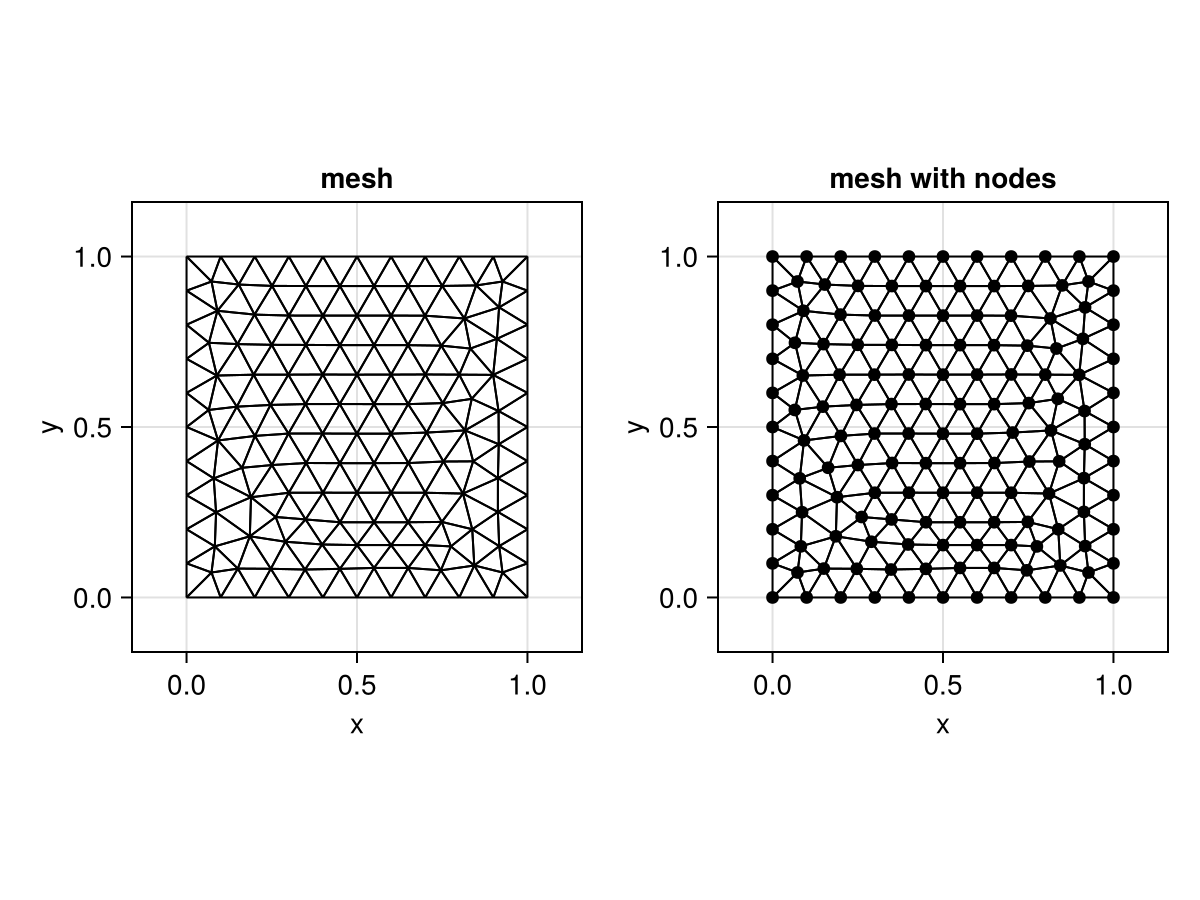

In [12]:
begin 
   fig = Figure()
   ax = Axis(fig[1,1], aspect = DataAspect(), xlabel = "x", ylabel = "y", title = "mesh")
   CairoMakie.triplot!(ax,xnode,ynode)
   ax = Axis(fig[1,2], aspect = DataAspect(), xlabel = "x", ylabel = "y", title = "mesh with nodes")
   CairoMakie.triplot!(ax,xnode,ynode,show_points = true)
   fig
end 

## Section 4: Stiffness Matrix and Load Vector Assembly

### Section 1.4: Stiffness Matrix Assembly  

In [24]:
# testing first ideas 
mesh    = meshFromGmsh("data/square-1.msh")
element = mesh.Elements[1]
v       = SVector(element.e1, element.e2, element.e3)
nnodes  = 3 
Iloc    = SVector{9}(v[i]+(j-1)*nnodes for i=1:3, j=1:3)

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


9-element SVector{9, Int64} with indices SOneTo(9):
  1
  2
  5
  4
  5
  8
  7
  8
 11

In [26]:
"""
    genLocStiffMat(element::Element)

Generates local stiffness matrix for single linear triangular element. 
"""
function genLocStiffMat(element::Element)
    nnodes = 3 
    v    = SVector(element.e1, element.e2, element.e3)   
    Emat = copy(element.Emat) 
    area = element.area 
    Iloc = SVector{9}(v[i]+(j-1)*nnodes for i=1:3, j=1:3)
    Jloc = SVector{9}(v[i]+(j-1)*nnodes for i=1:3, j=1:3) 
    Aloc = SMatrix{9,9}(1/area for i=1:9, j=1:9)
    return Iloc,Jloc,Aloc
end

"""
    genStiffMat(mesh::Mesh)

Generates global stiffness matrix on mesh of linear triangular elements. 
"""
function genStiffMat(mesh::Mesh)
 
    #..recover number of elements  
    nnodes      = mesh.nnodes 
    nelems      = mesh.nelems 
    dofPerElem  = mesh.dofPerElem
    dofPerElem2 = dofPerElem^2

    #..preallocate memory for globla matrix 
    A = zeros(3*nnodes,3*nnodes)

    #..loop over number of elements..
    for elementd in mesh.Elements 
        for elements in mesh.Elements 
            Iloc, Jloc, Aloc = genLocStiffMat(elements)
            A[Iloc,Jloc] += Aloc
        end
    end
    
    return A; 
end

genStiffMat

In [27]:
mesh = meshFromGmsh("data/square-1.msh");
A = genStiffMat(mesh)
display(A)

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


15×15 Matrix{Float64}:
 32.0  16.0   0.0  32.0  32.0   0.0  32.0  …  16.0  32.0  0.0  0.0  0.0  0.0
 16.0  32.0  16.0  16.0  32.0  16.0  16.0      0.0  32.0  0.0  0.0  0.0  0.0
  0.0  16.0  32.0  16.0  32.0  32.0  16.0     16.0  32.0  0.0  0.0  0.0  0.0
 32.0  16.0  16.0  48.0  48.0  16.0  48.0     32.0  48.0  0.0  0.0  0.0  0.0
 32.0  32.0  32.0  48.0  64.0  32.0  48.0     32.0  64.0  0.0  0.0  0.0  0.0
  0.0  16.0  32.0  16.0  32.0  32.0  16.0  …  16.0  32.0  0.0  0.0  0.0  0.0
 32.0  16.0  16.0  48.0  48.0  16.0  48.0     32.0  48.0  0.0  0.0  0.0  0.0
 32.0  32.0  32.0  48.0  64.0  32.0  48.0     32.0  64.0  0.0  0.0  0.0  0.0
  0.0  16.0  32.0  16.0  32.0  32.0  16.0     16.0  32.0  0.0  0.0  0.0  0.0
 16.0   0.0  16.0  32.0  32.0  16.0  32.0     32.0  32.0  0.0  0.0  0.0  0.0
 32.0  32.0  32.0  48.0  64.0  32.0  48.0  …  32.0  64.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0  0.0  0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0   0.0   0.0      0.0   

In [25]:
mesh = meshFromGmsh("data/square-1.msh");   @time genStiffMat(mesh); # <= force recompilation 
mesh = meshFromGmsh("data/square-10.msh");  @time genStiffMat(mesh); 
mesh = meshFromGmsh("data/square-100.msh"); @time genStiffMat(mesh); 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000019 seconds (1 allocation: 1.984 KiB)
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.002585 seconds (2 allocations: 1.385 MiB)
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
 96.541543 seconds (2 allocations: 9.389 GiB, 0.01% gc time)


In [51]:
"""
    genLocMassMat(element::Element)

Generates local mass matrix for single linear triangular element. 
"""
function genLocMassMat(element::Element)
    v    = SVector(element.e1, element.e2, element.e3)  
    Emat = copy(element.Emat)
    area = element.area 
    Iloc = SVector{9}(v[i] for j=1:3, i=1:3)
    Jloc = SVector{9}(v[i] for i=1:3, j=1:3) 
    Mmat = area/3*SMatrix{3,3}(1I) 
    Mloc = vec(Mmat)
    return Iloc, Jloc, Mloc
end

"""
    genMassMat(mesh::Mesh)

Generates global mass matrix on mesh of linear triangular elements. 
"""
function genMassMat(mesh::Mesh)
 
    #..recover number of elements  
    nnodes      = mesh.nnodes 
    nelems      = mesh.nelems 
    dofPerElem  = mesh.dofPerElem
    dofPerElem2 = dofPerElem^2

    #..set range vector 
    irng = SVector{9}(1:9)

    #..preallocate the memory for local matrix contributions 
    Mvalues = zeros(Float64,dofPerElem2*nelems)
    I = zeros(Int64,length(Mvalues))
    J = zeros(Int64,length(Mvalues)) 
    
    #..loop over number of elements..
    for element in mesh.Elements 
        Iloc, Jloc, Mloc = genLocMassMat(element) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Mvalues[irng] .= Mloc   
        irng = irng.+dofPerElem2
    end

    #..form sparse matrix
    M = sparse(I,J,Mvalues)
   
    return M; 
end

genMassMat

In [52]:
Iloc, Jloc, Mloc = genLocMassMat(refElem)
@test genLocMassMat(refElem) == (refElemIloc, refElemJloc, refElemMloc)

Test Passed

In [53]:
mesh = meshFromGmsh("data/square-1.msh");
M = genMassMat(mesh)
@test M == testM5node 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


Test Passed

In [54]:
mesh = meshFromGmsh("data/square-1.msh");   @time genMassMat(mesh); # <= force recompilation 
mesh = meshFromGmsh("data/square-10.msh");  @time genMassMat(mesh); 
mesh = meshFromGmsh("data/square-100.msh"); @time genMassMat(mesh); 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000009 seconds (13 allocations: 2.625 KiB)
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.000032 seconds (18 allocations: 104.188 KiB)
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
  0.002333 seconds (23 allocations: 9.511 MiB)


### Section 4.3: Right-Hand Side Assembly using Analytically Specified Source Function 

In [55]:
"""
    genLocVector(element::Element, sourceFct::Function)

Generates local load vector for single linear triangular element. 
""" 
function genLocVector(element::Element, sourceFct::Function)
    ploc = SVector(element.p1, element.p2, element.p3)   
    Iloc = SVector(element.e1, element.e2, element.e3)   
    area = element.area 
    floc = area/3*sourceFct.(ploc)
    return Iloc, floc
end

"""
    genVector(mesh, sourceFct::F) where F

Generates global load vector on mesh of linear triangular elements. 
"""
function genVector(mesh, sourceFct::F) where F 
 
    #..recover number of nodes  
    nnodes = mesh.nnodes 
     
    #..preallocate the memory for local matrix contributions 
    f = zeros(Float64,nnodes)

    #..loop over number of elements..
    for element in mesh.Elements
        Iloc, floc = genLocVector(element,sourceFct)
        f[Iloc] += floc 
    end
       
    return f; 
end

genVector

In [56]:
mesh = meshFromGmsh("data/square-1.msh");  
mySourceFct(x) = x[1]+x[2]
f = genVector(mesh,mySourceFct)
@test f ≈ testf5node 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'


Test Passed

In [57]:
mesh = meshFromGmsh("data/square-1.msh");   @time genVector(mesh,mySourceFct); # <= force recompilation
mesh = meshFromGmsh("data/square-10.msh");  @time genVector(mesh,mySourceFct); 
mesh = meshFromGmsh("data/square-100.msh"); @time genVector(mesh,mySourceFct); 

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000005 seconds (1 allocation: 96 bytes)
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.000004 seconds (1 allocation: 1.219 KiB)
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
  0.000079 seconds (2 allocations: 92.547 KiB)


## Section 4: FEM Solve  

In [60]:
"""
    genSolution(mesh,A,f)

Generates the finite element solution 
"""
function genSolution(mesh,A,f)
    A, f = handleBoundary!(mesh,A,f)
    u = A\f 
    return u 
end

genSolution

Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'


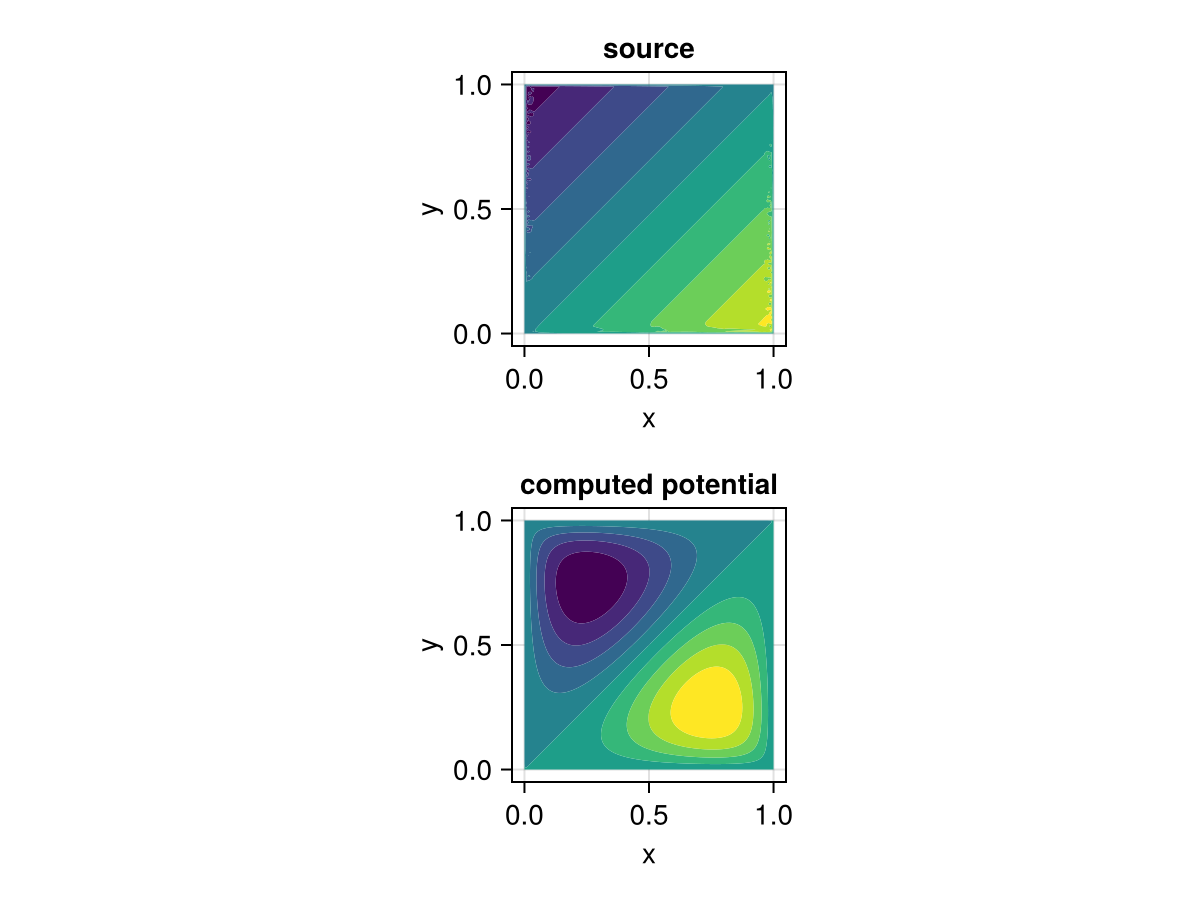

In [61]:
mesh = meshFromGmsh("data/square-100.msh");  
xnode,ynode = nodesFromGmsh("data/square-100.msh")
mySourceFct(x) = x[1]-x[2]
A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
u = genSolution(mesh,A,f)

begin 
   fig = Figure()
   ax = Axis(fig[1,1], aspect = DataAspect(), xlabel = "x", ylabel = "y", title = "source")
   CairoMakie.tricontourf!(ax, xnode,ynode,f)
   ax = Axis(fig[2,1], aspect = DataAspect(), xlabel = "x", ylabel = "y", title = "computed potential")
   CairoMakie.tricontourf!(ax, xnode,ynode,u)
   fig
end 

In [62]:
mesh = meshFromGmsh("data/square-1.msh");   
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution(mesh,A,f)

mesh = meshFromGmsh("data/square-10.msh");  
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution(mesh,A,f)

mesh = meshFromGmsh("data/square-100.msh"); 
@time A = genStiffMat(mesh); f= genVector(mesh,mySourceFct); 
@time u = genSolution(mesh,A,f);

Info    : Reading 'data/square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'data/square-1.msh'
  0.000005 seconds (14 allocations: 2.672 KiB)
  0.000014 seconds (12 allocations: 2.547 KiB)
Info    : Reading 'data/square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'data/square-10.msh'
  0.000020 seconds (19 allocations: 104.234 KiB)
  0.000199 seconds (90 allocations: 299.297 KiB)
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
  0.001854 seconds (24 allocations: 9.511 MiB)
  0.023383 seconds (101 allocations: 26.782 MiB)


In [95]:
# source function attached to the callable struct 
function mySourceFct(x)
    return (x[1]>0.)*(x[1]<0.2)*(x[2]>0.1)*(x[2]<0.9) - (x[1]>0.8)*(x[1]<1.)*(x[2]>0.1)*(x[2]<0.9)
end

mySourceFct (generic function with 1 method)

Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'
Info    : Reading 'data/square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'data/square-100.msh'


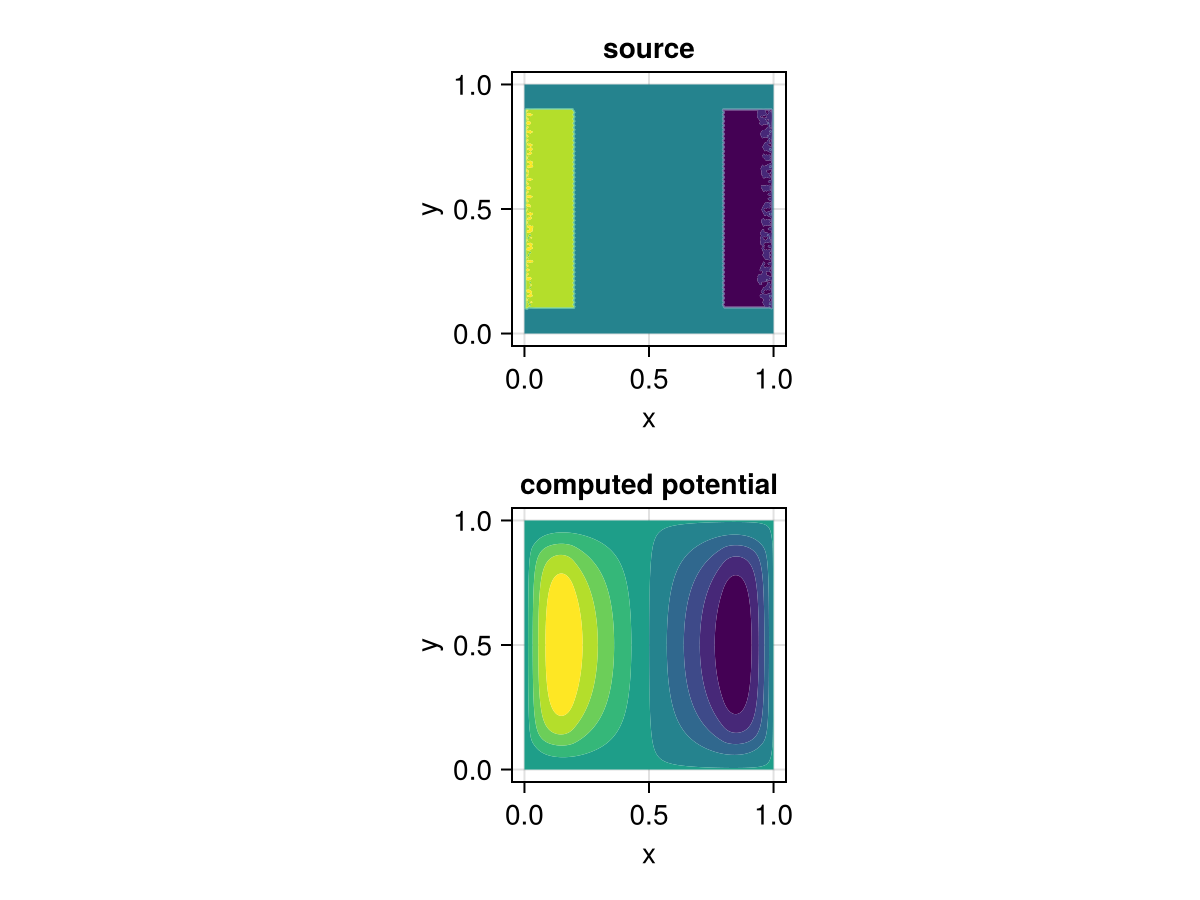

In [96]:
mesh = meshFromGmsh("data/square-100.msh"); 
xnode, ynode = nodesFromGmsh("data/square-100.msh")
A = genStiffMat(mesh); f = genVector(mesh,mySourceFct); 
u = genSolution(mesh,A,f);

begin 
   fig = Figure()
   ax = Axis(fig[1,1], aspect = DataAspect(), xlabel = "x", ylabel = "y", title = "source")
   CairoMakie.tricontourf!(ax, xnode,ynode,f)
   ax = Axis(fig[2,1], aspect = DataAspect(), xlabel = "x", ylabel = "y", title = "computed potential")
   CairoMakie.tricontourf!(ax, xnode,ynode,u)
   fig
end 

## Section 5: Write solution to VTK file 

In [100]:
using WriteVTK

In [103]:
points = [xnode ynode]'
cells = [MeshCell(VTKCellTypes.VTK_TRIANGLE, [element.e1, element.e2, element.e3]) for element in mesh.Elements]

vtk_grid("computed_solution", points, cells) do vtk
    vtk["potential",VTKPointData()] = u
    vtk["x-magnflux",VTKCellData()] = Bx 
    vtk["y-magnflux",VTKCellData()] = By
    vtk["mag-magnflux",VTKCellData()] = normB2 
    vtk_save(vtk) 
end

1-element Vector{String}:
 "computed_solution.vtu"